*Practical Data Science 21/22*
# Programming Assignment 2 - Predicting Video Game Sales

In this programming assignment you need to apply your new (or refreshed) machine learning knowledge. You will need to create a modeling pipeline training and evaluating a machine learning model build on several numeric as well as categorical features

## Introduction and Dataset

You are provided with a dataset containing a list of video games with sales greater than 100.000 copies. Your task is to build a model predicting the yearly global sales (column ``Global_Sales``) of a video game leveraging the available features.

To help you get started, the following blocks of code import the dataset using pandas: 

In [64]:
import pandas as pd

In [65]:
data_path = 'https://raw.githubusercontent.com/NikoStein/pds_data/main/data/video_game_sales.csv'
game_sales_data = pd.read_csv(data_path)
game_sales_data = game_sales_data[game_sales_data.Name.isna() == False]
game_sales_data.head()

,Name,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,82.53,76.0,51.0,8.0,322.0,E
1,Super Mario Bros.,NES,1985.0,Platform,40.24,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,32.77,80.0,73.0,8.0,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,NaN,NaN,NaN,NaN,NaN


## Splitting the Dataset

Before you can get started training a machine learning model you will have to split the dataframe into features and the target variable (try to use as many features as possible):

In [66]:
game_sales_data.set_index('Name', inplace=True)
game_sales_data.columns

Index(['Platform', 'Year_of_Release', 'Genre', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Rating'],
      dtype='object')

In [67]:
y = game_sales_data['Global_Sales']
X = game_sales_data.drop('Global_Sales', axis=1)
print(y.head())
print(X.head())

Name
Wii Sports                  82.53
Super Mario Bros.           40.24
Mario Kart Wii              35.52
Wii Sports Resort           32.77
Pokemon Red/Pokemon Blue    31.37
Name: Global_Sales, dtype: float64
                         Platform  Year_of_Release         Genre  \
Name                                                               
Wii Sports                    Wii           2006.0        Sports   
Super Mario Bros.             NES           1985.0      Platform   
Mario Kart Wii                Wii           2008.0        Racing   
Wii Sports Resort             Wii           2009.0        Sports   
Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   

                          Critic_Score  Critic_Count  User_Score  User_Count  \
Name                                                                           
Wii Sports                        76.0          51.0         8.0       322.0   
Super Mario Bros.                  NaN           NaN         NaN         

Next, you will have to create a train-test split in order to be able to evaluate your models. Use 80\% of the data for training and 20\% for evaluation (take a look at the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to identify the relevant parameters):

In [68]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 0)

## Removing missing values
If you inspect your training data you will find that some of the variables have missing values. Use the ``SimpleImputer`` to replace missing values in numerical columns with the column mean and missing values in categorical columns with the most frequent value (take a look at the SimpleImputer [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to identify the relevant parameters). You can decide if you want to use the simple or the advanced imputation strategy (or just try both).

In [69]:
from sklearn.impute import SimpleImputer

In [70]:
train_X.dtypes

Platform            object
Year_of_Release    float64
Genre               object
Critic_Score       float64
Critic_Count       float64
User_Score         float64
User_Count         float64
Rating              object
dtype: object

In [71]:
num_cols = [col for col in train_X.columns if train_X[col].dtype == 'float64']
cat_cols = [col for col in train_X.columns if train_X[col].dtype == 'object']

In [72]:
num_imputer = SimpleImputer(strategy='mean')

train_X_num_imputed = pd.DataFrame(num_imputer.fit_transform(train_X[num_cols]), 
                                   columns=num_cols, index=train_X.index)
val_X_num_imputed = pd.DataFrame(num_imputer.transform(val_X[num_cols]), 
                                   columns=num_cols, index=val_X.index)

cat_imputer = SimpleImputer(strategy='most_frequent')

train_X_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(train_X[cat_cols]), 
                                   columns=cat_cols, index=train_X.index)
val_X_cat_imputed = pd.DataFrame(cat_imputer.transform(val_X[cat_cols]), 
                                   columns=cat_cols, index=val_X.index)

## Encoding categorical variables

Prior to training your model you will have to encode the categorical variables. Inspect all categorical variables and use the ``OrdinalEncoder`` or the ``OneHotEncoder`` where appropriate. Remember that you have to combine the numerical as well as the label encoded and the one hot encoded dataframes at the end.

In [73]:
for cat in cat_cols:
    print("{}: {}".format(cat, game_sales_data[cat].nunique()))

Platform: 31
Genre: 12
Rating: 8


In [74]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [75]:
#see e.g. https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board for correct order
#see e.g. https://stackoverflow.com/questions/72170947/how-to-use-ordinalencoder-to-set-custom-order for more explanation
ordinal_encoder = OrdinalEncoder(categories=[['EC','E','K-A','E10+','T', 'M', 'AO', 'RP']])

train_X_cat_label = pd.DataFrame(ordinal_encoder.fit_transform(train_X_cat_imputed[["Rating"]]),
                                 columns=["Rating"], 
                                  index=train_X_cat_imputed.index)
val_X_cat_label = pd.DataFrame(ordinal_encoder.transform(val_X_cat_imputed[["Rating"]]),
                                 columns=["Rating"], 
                                 index=val_X_cat_imputed.index)

In [76]:
ohe_encoder = OneHotEncoder(sparse_output=False,)
train_X_cat_ohe = pd.DataFrame(ohe_encoder.fit_transform(train_X_cat_imputed[["Platform", 'Genre']]),
                                 index=train_X_cat_imputed.index, columns=ohe_encoder.get_feature_names_out())
val_X_cat_ohe = pd.DataFrame(ohe_encoder.transform(val_X_cat_imputed[["Platform", 'Genre']]),
                                 index=val_X_cat_imputed.index, columns=ohe_encoder.get_feature_names_out())

In [77]:
train_X = pd.concat([train_X_num_imputed, train_X_cat_label, train_X_cat_ohe], axis=1)
val_X = pd.concat([val_X_num_imputed, val_X_cat_label, val_X_cat_ohe], axis=1)

## Train the Model

Now our dataset should be ready and we can train a predictive model. Train a Decision Tree as well as a Random Forest and compare the in-sample as well as the out-of-sample performance of both models usinge the mean absolute error.

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score# Write your code here
import numpy as np

In [79]:
def score_dataset(X_train, X_valid, y_train, y_valid,depth= None):
    model_rf = RandomForestRegressor(n_estimators=100, random_state=1,max_depth=depth)
    model_rf.fit(X_train, y_train)
    preds_rf = model_rf.predict(X_valid)
    model_dt = DecisionTreeRegressor(random_state=1,max_depth=depth)
    model_dt.fit(X_train, y_train)
    preds_dt = model_dt.predict(X_valid)
    return mean_absolute_error(y_valid, preds_rf), mean_absolute_error(y_valid, preds_dt), model_rf, model_dt

In [80]:
oos_rf, oos_dt, model_rf, model_dt= score_dataset(train_X, val_X, train_y, val_y)
is_rf, is_dt, model_rf, model_dt = score_dataset(train_X, train_X, train_y, train_y)

In [81]:
print('Out-of-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(oos_rf, oos_dt))
print('------------------------------')
print('In-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(is_rf, is_dt))

Out-of-sample
Random Forest: 0.4334695197218959
Decicion Tree" 0.5181498358720199
------------------------------
In-sample
Random Forest: 0.22931049440241147
Decicion Tree" 0.12641105283767942


### Looks like Overfitting

In [82]:
#tree depth
model_dt.get_depth()

42

In [83]:
dt_scores_oos = []
dt_scores_is = []
rf_scores_oos = []
rf_scores_is = []
for i in range(1,42):
    oos_rf, oos_dt, model_rf, model_dt= score_dataset(train_X, val_X, train_y, val_y,depth=i)
    is_rf, is_dt, model_rf, model_dt = score_dataset(train_X, train_X, train_y, train_y,depth=i)
    dt_scores_is.append(is_dt)
    dt_scores_oos.append(oos_dt)
    rf_scores_is.append(is_rf)
    rf_scores_oos.append(oos_rf)

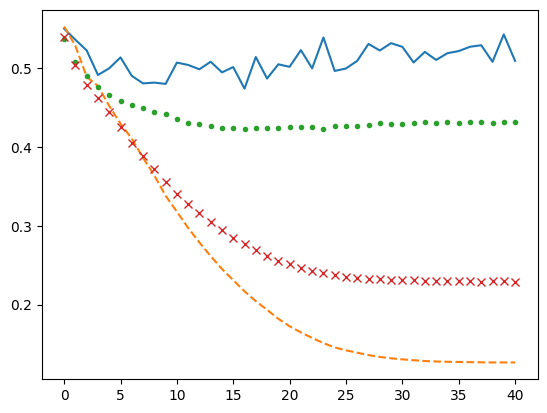

In [84]:
import matplotlib.pyplot as plt
plt.plot(dt_scores_oos,"-")
plt.plot(dt_scores_is,"--")
plt.plot(rf_scores_oos,".")
plt.plot(rf_scores_is,"x")
plt.show()

In [85]:
oos_rf, oos_dt, model_rf, model_dt= score_dataset(train_X, val_X, train_y, val_y,depth=10)
is_rf, is_dt, model_rf, model_dt = score_dataset(train_X, train_X, train_y, train_y,depth=10)

In [86]:
print('Out-of-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(oos_rf, oos_dt))
print('------------------------------')
print('In-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(is_rf, is_dt))

Out-of-sample
Random Forest: 0.44150895074300234
Decicion Tree" 0.48015531209599804
------------------------------
In-sample
Random Forest: 0.35564943924730624
Decicion Tree" 0.3381196860663547


### Use a Pipeline

In [109]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [110]:
train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 0)

In [111]:
# Preprocessing numerical columns
numerical_transformer = SimpleImputer(strategy='mean')

## Preprocessing categorical columns

# Ordinal Encoder
categorical_transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['EC','E','K-A','E10+','T', 'M', 'AO', 'RP']])) 
])

# One hot encoder
categorical_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# Bundle the preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_cols),
    ('cat_ordinal', categorical_transformer_ordinal, ['Rating']),
    ('cat_ohe', categorical_transformer_ohe, ["Platform", "Genre"])
])

In [112]:
# Create model
model = RandomForestRegressor(n_estimators=100, random_state=1,max_depth=10)


# Bundle preprocessing and modeling code in a pipeline
complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Preprocess the raw training data and fit the model
complete_pipeline.fit(train_X, train_y)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline.predict(val_X)

# Evaluate the model
score = mean_absolute_error(val_y, preds)
print("MAE using the complete pipeline: {}".format(score))

MAE using the complete pipeline: 0.4404769639699466


## Improve the Model

Having successfully trained a model, your next task is to improve its performance. Try different advanced feature engineering techniques and see if they are able to improve your model.  

### Catboost Encoding

In [ ]:
!pip install category_encoders
from category_encoders import CatBoostEncoder

In [91]:
train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 0)

In [92]:
num_cols = [col for col in train_X.columns if train_X[col].dtype == 'float64']
cat_cols = [col for col in train_X.columns if train_X[col].dtype == 'object']

num_imputer = SimpleImputer(strategy='mean')

train_X_num_imputed = pd.DataFrame(num_imputer.fit_transform(train_X[num_cols]), 
                                   columns=num_cols, index=train_X.index)
val_X_num_imputed = pd.DataFrame(num_imputer.transform(val_X[num_cols]), 
                                   columns=num_cols, index=val_X.index)

cat_imputer = SimpleImputer(strategy='most_frequent')

train_X_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(train_X[cat_cols]), 
                                   columns=cat_cols, index=train_X.index)
val_X_cat_imputed = pd.DataFrame(cat_imputer.transform(val_X[cat_cols]), 
                                   columns=cat_cols, index=val_X.index)

In [93]:
catboost_encoder = CatBoostEncoder()

train_X_catboostenc = catboost_encoder.fit_transform(train_X_cat_imputed, train_y)
val_X_catboostenc = catboost_encoder.transform(val_X_cat_imputed)

In [94]:
train_X = pd.concat([train_X_num_imputed, train_X_catboostenc], axis=1)
val_X = pd.concat([val_X_num_imputed, val_X_catboostenc], axis=1)

In [95]:
oos_rf, oos_dt,_,_ = score_dataset(train_X, val_X, train_y, val_y,depth=10)
is_rf, is_dt,_,_ = score_dataset(train_X, train_X, train_y, train_y,depth=10)

In [96]:
print('Out-of-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(oos_rf, oos_dt))
print('------------------------------')
print('In-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(is_rf, is_dt))

Out-of-sample
Random Forest: 0.44412214683015294
Decicion Tree" 0.471083693376261
------------------------------
In-sample
Random Forest: 0.35053492916009565
Decicion Tree" 0.33296529658130486


### Advanced Imputation

In [97]:
train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 0)

# Find all columns with missing values:
cols_with_missing = train_X.columns.values[train_X.isna().sum() > 0]

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    train_X[col + '_was_missing'] = train_X[col].isnull()
    val_X[col + '_was_missing'] = val_X[col].isnull()
    
    
num_cols = [col for col in train_X.columns if train_X[col].dtype == 'float64']
cat_cols = [col for col in train_X.columns if train_X[col].dtype == 'object']
bool_cols = [col for col in train_X.columns if train_X[col].dtype == 'bool']
    
# Imputation
num_imputer = SimpleImputer(strategy='mean')
train_X_num_imputed = pd.DataFrame(num_imputer.fit_transform(train_X[num_cols]),
                              columns=num_cols, index = train_X.index)
val_X_num_imputed = pd.DataFrame(num_imputer.transform(val_X[num_cols]),
                            columns=num_cols, index = val_X.index)

cat_imputer = SimpleImputer(strategy='most_frequent')
train_X_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(train_X[cat_cols]), 
                                   columns=cat_cols, index=train_X.index)
val_X_cat_imputed = pd.DataFrame(cat_imputer.transform(val_X[cat_cols]), 
                                   columns=cat_cols, index=val_X.index)

train_X = pd.concat([train_X_num_imputed, train_X_cat_imputed, train_X[bool_cols]], axis=1)
val_X = pd.concat([val_X_num_imputed, val_X_cat_imputed, val_X[bool_cols]], axis=1)

In [98]:
# Encodings
ordinal_encoder = OrdinalEncoder(categories=[['EC','E','K-A','E10+','T', 'M', 'AO', 'RP']])
train_X_cat_label = pd.DataFrame(ordinal_encoder.fit_transform(train_X_cat_imputed[["Rating"]]),
                                 columns=["Rating"], 
                                 index=train_X_cat_imputed.index)
val_X_cat_label = pd.DataFrame(ordinal_encoder.transform(val_X_cat_imputed[["Rating"]]),
                                 columns=["Rating"], 
                                 index=val_X_cat_imputed.index)


ohe_encoder = OneHotEncoder(sparse_output=False)
train_X_cat_ohe = pd.DataFrame(ohe_encoder.fit_transform(train_X_cat_imputed[["Platform", 'Genre']]),
                                 index=train_X_cat_imputed.index, columns=ohe_encoder.get_feature_names_out())
val_X_cat_ohe = pd.DataFrame(ohe_encoder.transform(val_X_cat_imputed[["Platform", 'Genre']]),
                                 index=val_X_cat_imputed.index, columns=ohe_encoder.get_feature_names_out())

train_X = pd.concat([train_X_num_imputed, train_X_cat_label, train_X_cat_ohe], axis=1)
val_X = pd.concat([val_X_num_imputed, val_X_cat_label, val_X_cat_ohe], axis=1)

In [99]:
oos_rf, oos_dt,_,_ = score_dataset(train_X, val_X, train_y, val_y,depth=10)
is_rf, is_dt,_,_ = score_dataset(train_X, train_X, train_y, train_y,depth=10)

print('Out-of-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(oos_rf, oos_dt))
print('------------------------------')
print('In-sample\nRandom Forest: {}\nDecicion Tree" {}'.format(is_rf, is_dt))

Out-of-sample
Random Forest: 0.44150895074300234
Decicion Tree" 0.48015531209599804
------------------------------
In-sample
Random Forest: 0.35564943924730624
Decicion Tree" 0.3381196860663547


## Are blockbuster Title relevant?

In [100]:
game_sales_data[game_sales_data["Global_Sales"]>10].index

Index(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii',
       'Wii Sports Resort', 'Pokemon Red/Pokemon Blue', 'Tetris',
       'New Super Mario Bros.', 'Wii Play', 'New Super Mario Bros. Wii',
       'Duck Hunt', 'Nintendogs', 'Mario Kart DS',
       'Pokemon Gold/Pokemon Silver', 'Wii Fit', 'Kinect Adventures!',
       'Wii Fit Plus', 'Grand Theft Auto V', 'Grand Theft Auto: San Andreas',
       'Super Mario World', 'Brain Age: Train Your Brain in Minutes a Day',
       'Pokemon Diamond/Pokemon Pearl', 'Super Mario Land',
       'Super Mario Bros. 3', 'Grand Theft Auto V',
       'Grand Theft Auto: Vice City', 'Pokemon Ruby/Pokemon Sapphire',
       'Brain Age 2: More Training in Minutes a Day',
       'Pokemon Black/Pokemon White', 'Gran Turismo 3: A-Spec',
       'Call of Duty: Modern Warfare 3',
       'Pokémon Yellow: Special Pikachu Edition', 'Call of Duty: Black Ops 3',
       'Call of Duty: Black Ops', 'Pokemon X/Pokemon Y',
       'Call of Duty: Black Ops II', 'Call of D

In [101]:
block_buster = ["Mario","Pokemon","Grand Theft Auto","Call of Duty"]

In [102]:
game_sales_data["blockbuster"] = [
        any(block_buster_title in title for block_buster_title in block_buster)
        for title in game_sales_data.index
    ]

In [103]:
game_sales_data

,Platform,Year_of_Release,Genre,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating,blockbuster
Name,,,,,,,,,,
Wii Sports,Wii,2006.0,Sports,82.53,76.0,51.0,8.0,322.0,E,False
Super Mario Bros.,NES,1985.0,Platform,40.24,NaN,NaN,NaN,NaN,NaN,True
Mario Kart Wii,Wii,2008.0,Racing,35.52,82.0,73.0,8.3,709.0,E,True
Wii Sports Resort,Wii,2009.0,Sports,32.77,80.0,73.0,8.0,192.0,E,False
Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...
Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.01,NaN,NaN,NaN,NaN,NaN,False
LMA Manager 2007,X360,2006.0,Sports,0.01,NaN,NaN,NaN,NaN,NaN,False
Haitaka no Psychedelica,PSV,2016.0,Adventure,0.01,NaN,NaN,NaN,NaN,NaN,False


In [104]:
Y = game_sales_data["Global_Sales"]
X = game_sales_data.drop("Global_Sales", axis=1)

In [105]:
train_X, val_X, train_y, val_y = train_test_split(X, y, 
                                                  train_size=0.8, 
                                                  random_state = 0)

In [106]:
# Preprocessing numerical columns (Median instead of mean because of outliers)
numerical_transformer = SimpleImputer(strategy='median')

## Preprocessing categorical columns

# Ordinal Encoder
categorical_transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['EC','E','K-A','E10+','T', 'M', 'AO', 'RP']])) 
])

# One hot encoder
categorical_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

# Bundle the preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, num_cols),
    ('cat_ordinal', categorical_transformer_ordinal, ['Rating']),
    ('cat_ohe', categorical_transformer_ohe, ["Platform", "Genre","blockbuster"])
])


In [107]:

# Create model
model = RandomForestRegressor(n_estimators=100, random_state=1,max_depth=10)


# Bundle preprocessing and modeling code in a pipeline
complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Preprocess the raw training data and fit the model
complete_pipeline.fit(train_X, train_y)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline.predict(val_X)

# Evaluate the model
score = mean_absolute_error(val_y, preds)
print("MAE using the complete pipeline: {}".format(score))

MAE using the complete pipeline: 0.4190883514878095


## One more thing

Advanced Imputation between the different scores could have been also a good Idea

In [108]:
X[num_cols].corr()

,Year_of_Release,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.000000,0.010810,0.223010,-0.243520,0.175409
Critic_Score,0.010810,1.000000,0.425721,0.541944,0.264346
Critic_Count,0.223010,0.425721,1.000000,0.186908,0.362549
User_Score,-0.243520,0.541944,0.186908,1.000000,0.027060
User_Count,0.175409,0.264346,0.362549,0.027060,1.000000
